## Choosing Switches

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import glob
import pareto_front

We first import the switch data. This was given to me by Samantha Coday.

In [2]:
switchdata = pd.read_csv('Switches - Sheet1.csv')  
switchdata.columns
switchdata['fom_coss_rdson'] = switchdata["Coss (pF)"]*switchdata['Rds,on (mOHms)']

We now filter for switches rated for higher than 40V and 10A.

In [3]:
switches = switchdata[(switchdata['Voltage Rating (V)'] > 40) & (switchdata['Current Rating (A)'] > 10)&(switchdata['fom_coss_rdson'] >= 30)]

switches['Volume (mm^3)'];
switches['fom_coss_rdson'];


0     1760.0
1     1750.0
2     1750.0
5     3000.0
6     3000.0
7     3000.0
9     3100.0
10    3283.0
11    3250.0
12    3250.0
13    3250.0
14    3175.0
15    3175.0
16    3175.0
17    3150.0
18    3175.0
19    3150.0
29    1530.0
35    2760.0
36    1441.8
37    2050.0
38    1980.0
39    1980.0
46    2520.0
47    2380.0
49    1652.0
50    2408.0
51    1337.6
52    1990.2
53    2400.0
54    2016.0
55    1348.8
56    1400.0
57    2400.0
58    1815.6
62    4320.0
63    1950.0
64    3150.0
65    3846.0
66    2340.0
68    3960.0
69    3960.0
70    3960.0
Name: fom_coss_rdson, dtype: float64

Next we want to find the Pareto front of the volume and the FOM defined by Coss and Rdson.

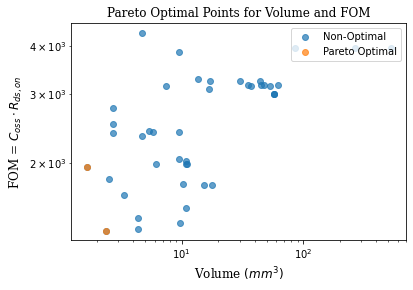

In [9]:

vol = np.asarray(switches['Volume (mm^3)'])
fom = np.asarray(switches['fom_coss_rdson'])

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

plt.title('Pareto Optimal Points for Volume and FOM', fontdict=font)
plt.xlabel('Volume $(mm^3)$', fontdict=font)
plt.ylabel('FOM = $C_{oss} \cdot R_{ds,on}$ ', fontdict=font)
from pareto_front import pareto_frontier

# Find minimizing pareto front for volume and the FOM
p_front = pareto_frontier(vol, fom, maxX = False, maxY = False) 

plt.scatter(vol, fom,alpha=0.7)
plt.scatter(p_front[0], p_front[1],alpha=0.7)
plt.yscale('log',base=10) 
plt.legend(['Non-Optimal','Pareto Optimal'], loc = 'upper right')
plt.xscale('log',base=10) 
plt.savefig("SwitchmyImage.png", dpi=600)


plt.show()


In [243]:
switches.loc[switches['fom_coss_rdson'].isin(p_front[1])]

,Manufacturer,Part Number,Voltage Rating (V),Current Rating (A),Coss (pF),"Rds,on (mOHms)",Qg (nC),Length (mm),Width (mm),Height (mm),Volume (mm^3),Price ($),Link,"FOM 1: (Coss*Rds,on*Volume",fom_coss_rdson
51,EPC,EPC2204,100.0,29.0,304.0,4.4,5.7,2.5,1.500,0.638,2.39,1.8041,https://epc-co.com/epc/Portals/0/epc/documents...,1337.6,1337.6
63,EPC,EPC2207,200.0,14.0,130.0,15.0,4.5,2.8,0.925,0.638,1.65,2.3595,https://epc-co.com/epc/Portals/0/epc/documents...,1950,1950.0


## Capacitor Methodology: Choosing C1
Here we apply the same methodology to the capacitors. Here however we need to import all the data downloaded directly from Digikey for capacitors rated for 50+ Volts. They are also filtered to just include X6S, X6R, X7S, X7R rated caps as well. These go up to 105+ degrees Celsius, which is appropriate for higher temperate applications.

After importing them we calculate the volume using the function volumecalc_ceram.

In [11]:
path = "ceramic_capacitors_2022-05-08/"

filenames = glob.glob(path + "/*.csv")
data_all = pd.DataFrame()

for file in filenames:
   # reading csv files
   data_all = pd.concat([data_all, pd.read_csv(file)])

dfcap_ceram = data_all

In [12]:
def volumecalc_ceram(df):
    
    volumes_mm = []
    for i in range(0,df.shape[0]):
        
        if df['Size / Dimension'].values[i] == '-':
            volume = "-"
            
        #determine the type of cap shape and then define thickness, length, width.
        elif df['Height - Seated (Max)'].values[i] == '-':

            length = pd.to_numeric(re.findall(r'((?<=\()[\d\.]*)', df['Size / Dimension'].values[i])[0])
            width = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Size / Dimension'].values[i])[0])

            if df['Thickness (Max)'].values[i] != "-":
                thickness = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Thickness (Max)'].values[i])[0])
                volume = length * width * thickness
            else:
                volume = "-"

            #cylinder
        else:
            #now we compute volume

            diameter = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Size / Dimension'].values[i])[0])
            height = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Height - Seated (Max)'].values[i])[0])
            
            volume = np.pi * ((diameter/2)**2) * height

            
        volumes_mm.append(volume)
  
    df['volume_mm'] = volumes_mm

    return df

In [13]:
volumecalc_ceram(dfcap_ceram) # ['voltage_rated']

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Applications,Failure Rate,Mounting Type,Package / Case,Size / Dimension,Height - Seated (Max),Thickness (Max),Lead Spacing,Lead Style,volume_mm
0,https://product.tdk.com/en/system/files?file=d...,//media.digikey.com/photos/TDK%20Photos/CKG45K...,"445-10378-2-ND,445-10378-1-ND,445-10378-6-ND",CKG45KX7S1H475M290JJ,TDK Corporation,TDK Corporation,CAP CER 4.7UF 50V X7S SMD,0,2.2594,0,...,"Automotive, SMPS Filtering, Bypass, Decoupling",-,"Surface Mount, MLCC","SMD, J-Lead","0.197"" L x 0.138"" W (5.00mm x 3.50mm)",-,"0.118"" (3.00mm)",-,J-Lead,52.5
1,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2220Y0500155JXT-ND,2220Y0500155JXT,Knowles Syfer,Knowles Syfer,CAP CER 1.5UF 50V X7R 2220,0,2.27956,0,...,Boardflex Sensitive,-,"Surface Mount, MLCC",2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.165"" (4.20mm)",-,-,119.7
2,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2220Y0630155JXT-ND,2220Y0630155JXT,Knowles Syfer,Knowles Syfer,CAP CER 1.5UF 63V X7R 2220,0,2.27956,0,...,Boardflex Sensitive,-,"Surface Mount, MLCC",2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.165"" (4.20mm)",-,-,119.7
3,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2225J0500105MXT-ND,2225J0500105MXT,Knowles Syfer,Knowles Syfer,CAP CER 1UF 50V X7R 2225,0,2.29644,0,...,General Purpose,-,"Surface Mount, MLCC",2225 (5763 Metric),"0.224"" L x 0.248"" W (5.70mm x 6.30mm)",-,"0.098"" (2.50mm)",-,-,89.775
4,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2225J0630105MXT-ND,2225J0630105MXT,Knowles Syfer,Knowles Syfer,CAP CER 1UF 63V X7R 2225,0,2.29644,0,...,General Purpose,-,"Surface Mount, MLCC",2225 (5763 Metric),"0.224"" L x 0.248"" W (5.70mm x 6.30mm)",-,"0.098"" (2.50mm)",-,-,89.775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMC57CG...,2571-GMC43X7R685K50NTTR-ND,GMC43X7R685K50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 6.8UF 50V X7R 1812,"12,500",0.48,0,...,General Purpose,-,"Surface Mount, MLCC",1812 (4532 Metric),"0.177"" L x 0.126"" W (4.50mm x 3.20mm)",-,"0.118"" (3.00mm)",-,-,43.2
96,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMCxx_s...,2571-GMC32X7R106K63NTTR-ND,GMC32X7R106K63NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP1210 X7R 10UF 10% 63V,"6,000",0.48,0,...,General Purpose,-,"Surface Mount, MLCC",1210 (3225 Metric),"0.126"" L x 0.098"" W (3.20mm x 2.50mm)",-,"0.071"" (1.80mm)",-,-,14.4
97,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMC57CG...,2571-GMC55X7R335K50NTTR-ND,GMC55X7R335K50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 3.3UF 50V X7R 2220,"20,000",0.6,0,...,General Purpose,-,"Surface Mount, MLCC",2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.138"" (3.50mm)",-,-,99.75
98,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMCxx_s...,2571-GMC55X7R475M50NTTR-ND,GMC55X7R475M50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP2220 X7R 4.7UF 20% 50V,"11,000",0.6,0,...,General Purpose,-,"Surface Mount, MLCC",2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.138"" (3.50mm)",-,-,99.75


In [14]:
#filter out rows with invalid (non-numeric)
dfcap_ceram = dfcap_ceram[~dfcap_ceram.Price.str.contains('[\d\.]*', regex= True, na=False)]
dfcap_ceram = dfcap_ceram[dfcap_ceram.volume_mm != "-"]

Now we compute the energy density. We use the Quantiphy package to get the value in F instead of uF and to get rid of the symbolic values.

In [15]:
from quantiphy import Quantity
import pandas as pd
import numpy as np
def energydensity(df):
    #df = df[df['voltage_rated'] != '-']
    X = []
    V=[]
    energy = []
    energydensity = []
    k = 0.4;  #normalized derating of differential capacitance
    k2 = 4*k/(np.sqrt(k)+1)**2; 

    for i in range(0,len(df['Capacitance'])):
        x = df['Capacitance'].values[i].replace("F", "")
        X.append(Quantity(x))
        X[i].render(False)
        V.append(Quantity(df['Voltage - Rated'].values[i]))
        #V[i].render(False)
        energy.append(0.5*k2*X[i]*V[i]**2);   
        print(energy[i]/df['volume_mm'].values[i])
        energydensity.append(energy[i]/df['volume_mm'].values[i])


    df['capacitance_absolute'] = X;
    df['energy'] = energy
    df['energy_density'] = energydensity
    return df




In [16]:
energydensity(dfcap_ceram)



6.718708982893617e-05
9.404687825998904e-06
1.493088239255586e-05
8.359722511999025e-06
1.3271895460049654e-05
0.00013240699009080888
0.00013240699009080888
8.359722511999025e-06
1.3271895460049654e-05
0.00013240699009080888
1.2539583767998542e-05
1.9907843190074482e-05
1.2539583767998542e-05
1.9907843190074482e-05
1.003166701439883e-05
1.5926274552059584e-05
8.359722511999025e-06
1.3271895460049654e-05
3.1771224498390694e-05
8.359722511999025e-06
1.3271895460049654e-05
2.4975252408007422e-05
2.4975252408007422e-05
7.147562747759167e-05
2.0847058014297568e-05
3.309678930349882e-05
2.0847058014297568e-05
3.309678930349882e-05
1.2539583767998542e-05
1.9907843190074482e-05
3.392063676902656e-05
1.003166701439883e-05
1.5926274552059584e-05
2.0847058014297568e-05
3.309678930349882e-05
2.0847058014297568e-05
3.309678930349882e-05
2.4975252408007422e-05
2.4975252408007422e-05
8.359722511999025e-06
1.3271895460049654e-05
2.501646961715708e-05
3.971614716419858e-05
2.501646961715708e-05
3.97161

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Package / Case,Size / Dimension,Height - Seated (Max),Thickness (Max),Lead Spacing,Lead Style,volume_mm,capacitance_absolute,energy,energy_density
0,https://product.tdk.com/en/system/files?file=d...,//media.digikey.com/photos/TDK%20Photos/CKG45K...,"445-10378-2-ND,445-10378-1-ND,445-10378-6-ND",CKG45KX7S1H475M290JJ,TDK Corporation,TDK Corporation,CAP CER 4.7UF 50V X7S SMD,0,2.2594,0,...,"SMD, J-Lead","0.197"" L x 0.138"" W (5.00mm x 3.50mm)",-,"0.118"" (3.00mm)",-,J-Lead,52.5,0.000005,0.003527,0.000067
1,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2220Y0500155JXT-ND,2220Y0500155JXT,Knowles Syfer,Knowles Syfer,CAP CER 1.5UF 50V X7R 2220,0,2.27956,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.165"" (4.20mm)",-,-,119.7,0.000002,0.001126,0.000009
2,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2220Y0630155JXT-ND,2220Y0630155JXT,Knowles Syfer,Knowles Syfer,CAP CER 1.5UF 63V X7R 2220,0,2.27956,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.165"" (4.20mm)",-,-,119.7,0.000002,0.001787,0.000015
3,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2225J0500105MXT-ND,2225J0500105MXT,Knowles Syfer,Knowles Syfer,CAP CER 1UF 50V X7R 2225,0,2.29644,0,...,2225 (5763 Metric),"0.224"" L x 0.248"" W (5.70mm x 6.30mm)",-,"0.098"" (2.50mm)",-,-,89.775,0.000001,0.000750,0.000008
4,https://www.knowlescapacitors.com/getattachmen...,//media.digikey.com/Renders/Knowles%20Syfer/22...,2225J0630105MXT-ND,2225J0630105MXT,Knowles Syfer,Knowles Syfer,CAP CER 1UF 63V X7R 2225,0,2.29644,0,...,2225 (5763 Metric),"0.224"" L x 0.248"" W (5.70mm x 6.30mm)",-,"0.098"" (2.50mm)",-,-,89.775,0.000001,0.001191,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMC57CG...,2571-GMC43X7R685K50NTTR-ND,GMC43X7R685K50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 6.8UF 50V X7R 1812,"12,500",0.48,0,...,1812 (4532 Metric),"0.177"" L x 0.126"" W (4.50mm x 3.20mm)",-,"0.118"" (3.00mm)",-,-,43.2,0.000007,0.005103,0.000118
96,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMCxx_s...,2571-GMC32X7R106K63NTTR-ND,GMC32X7R106K63NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP1210 X7R 10UF 10% 63V,"6,000",0.48,0,...,1210 (3225 Metric),"0.126"" L x 0.098"" W (3.20mm x 2.50mm)",-,"0.071"" (1.80mm)",-,-,14.4,0.000010,0.011915,0.000827
97,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMC57CG...,2571-GMC55X7R335K50NTTR-ND,GMC55X7R335K50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 3.3UF 50V X7R 2220,"20,000",0.6,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.138"" (3.50mm)",-,-,99.75,0.000003,0.002477,0.000025
98,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMCxx_s...,2571-GMC55X7R475M50NTTR-ND,GMC55X7R475M50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP2220 X7R 4.7UF 20% 50V,"11,000",0.6,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.138"" (3.50mm)",-,-,99.75,0.000005,0.003527,0.000035


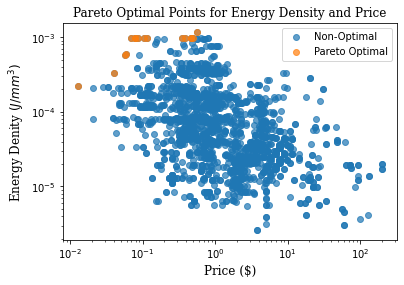

In [17]:
energy = np.asarray(dfcap_ceram['energy_density'])
price = np.asarray(dfcap_ceram['Price'])

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

percentile_list = pd.DataFrame(
    {'energy': energy,
     'price': price,
    })

pare = percentile_list[percentile_list['energy'].notnull()]
pare = percentile_list[percentile_list['price'].notnull()]

#pareto_frontier(pare['price'].tolist(), pare['energy'].tolist(), maxX = True, maxY =True)

plt.title('Pareto Optimal Points for Energy Density and Price', fontdict=font)
plt.xlabel('Price ($)', fontdict=font)
plt.ylabel('Energy Denity $(J/mm^3)$ ', fontdict=font)
# Find minimizing pareto front for volume and the FOM
p_front = pareto_front.pareto_frontier(pare['price'].tolist(), pare['energy'].tolist(), maxX = False, maxY =True)
# Plot a scatter graph of all results
plt.scatter(price, energy, alpha=0.7)
# Then plot the Pareto frontier on top
plt.scatter(p_front[0], p_front[1],alpha=0.7)
plt.yscale('log',base=10) 
plt.legend(['Non-Optimal','Pareto Optimal'], loc = 'upper right')
plt.xscale('log',base=10) 
plt.savefig("capacitors_2d.png", format="png", dpi=600)

plt.show()

In [135]:
dfcap_ceram.loc[dfcap_ceram['energy_density'].isin(p_front[1])]

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Package / Case,Size / Dimension,Height - Seated (Max),Thickness (Max),Lead Spacing,Lead Style,volume_mm,capacitance_absolute,energy,energy_density
13,http://www.samsungsem.com/kr/support/product-s...,//media.digikey.com/Renders/Samsung%20Electro-...,CL21B105KBFNNNF-ND,CL21B105KBFNNNF,Samsung Electro-Mechanics,Samsung Electro-Mechanics,CAP CER 1UF 50V X7R 0805,0,0.01273,0,...,0805 (2012 Metric),"0.079"" L x 0.049"" W (2.00mm x 1.25mm)",-,"0.053"" (1.35mm)",-,-,3.375,0.000001,0.000750,0.000222
16,http://www.passivecomponent.com/wp-content/upl...,//media.digikey.com/Photos/Walsin%20Tech/1210-...,1292-1210B106K500CTTR-ND,1210B106K500CT,Walsin Technology Corporation,Walsin Technology Corporation,MLCC 10UF 50V X7R 1210,0,0.04055,0,...,1210 (3225 Metric),"0.126"" L x 0.098"" W (3.20mm x 2.50mm)",-,"0.110"" (2.80mm)",-,-,22.4,0.000010,0.007505,0.000335
32,https://www.murata.com/-/media/webrenewal/supp...,//media.digikey.com/Renders/Murata%20Renders/0...,GRM21BC81H475ME11K-ND,GRM21BC81H475ME11K,Murata Electronics,Murata Electronics,CAP CER 4.7UF 50V X6S 0805,0,0.06834,0,...,0805 (2012 Metric),"0.079"" L x 0.049"" W (2.00mm x 1.25mm)",-,"0.057"" (1.45mm)",-,-,3.625,0.000005,0.003527,0.000973
36,https://search.murata.co.jp/Ceramy/image/img/A...,//media.digikey.com/Renders/Murata%20Renders/0...,490-GRM21BZ71H475ME15KTR-ND,GRM21BZ71H475ME15K,Murata Electronics,Murata Electronics,CAP CER 4.7UF 50V X7R 0805,0,0.07762,0,...,0805 (2012 Metric),"0.079"" L x 0.049"" W (2.00mm x 1.25mm)",-,"0.057"" (1.45mm)",-,-,3.625,0.000005,0.003527,0.000973
37,https://search.murata.co.jp/Ceramy/image/img/A...,//media.digikey.com/Renders/Murata%20Renders/0...,GRM21BC81H475ME11L-ND,GRM21BC81H475ME11L,Murata Electronics,Murata Electronics,CAP CER 4.7UF 50V X6S 0805,0,0.0781,0,...,0805 (2012 Metric),"0.079"" L x 0.049"" W (2.00mm x 1.25mm)",-,"0.057"" (1.45mm)",-,-,3.625,0.000005,0.003527,0.000973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,https://product.tdk.com/en/system/files?file=d...,//media.digikey.com/Renders/TDK%20Renders/1210...,"445-7983-2-ND,445-7983-1-ND,445-7983-6-ND",CGA6P3X7S1H106M250AE,TDK Corporation,TDK Corporation,CAP CER 10UF 50V X7S 1210,56,1.39,0,...,1210 (3225 Metric),"0.126"" L x 0.098"" W (3.20mm x 2.50mm)",-,"0.110"" (2.80mm)",-,-,22.4,0.000010,0.007505,0.000335
57,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMC10CG...,2571-GMC10X7R105K50NTTR-ND,GMC10X7R105K50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 1UF 50V X7R 0603,"6,132,000",0.057,0,...,0603 (1608 Metric),"0.063"" L x 0.031"" W (1.60mm x 0.80mm)",-,"0.039"" (1.00mm)",-,-,1.28,0.000001,0.000750,0.000586
61,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMCxx_s...,2571-GMC10X7R105M50NTTR-ND,GMC10X7R105M50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP0603 X7R 1UF 20% 50V,"6,132,000",0.09,0,...,0603 (1608 Metric),"0.063"" L x 0.031"" W (1.60mm x 0.80mm)",-,"0.039"" (1.00mm)",-,-,1.28,0.000001,0.000750,0.000586
89,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMC57CG...,2571-GMC32X7R106K50NTTR-ND,GMC32X7R106K50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 10UF 50V X7R 1210,"1,905,000",0.369,0,...,1210 (3225 Metric),"0.126"" L x 0.098"" W (3.20mm x 2.50mm)",-,"0.110"" (2.80mm)",-,-,22.4,0.000010,0.007505,0.000335


Now we might want to do some kind of selection based on more than two variables. Using Jamie Bull's other code we do a 3D optimization. We filter a new dataset with just the variables of interest, and then put them into list form.

In [18]:
df3d = dfcap_ceram.filter(['Price','energy_density', 'capacitance_absolute'], axis=1)

In [19]:
df3d['Price'] = pd.to_numeric(df3d['Price'])
df3d['Price'] = -1*df3d['Price']
dataset2 = df3d.values.tolist()

In [21]:
def simple_cull(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow, row):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)  

import random
#inputPoints = [[random.randint(70,100) for i in range(3)] for j in range(500)]
inputPoints = dataset2
paretoPoints, dominatedPoints = simple_cull(inputPoints, dominates)

Now we plot the data in 3D form.

(17, 3) (1437, 3)


<Figure size 432x288 with 0 Axes>

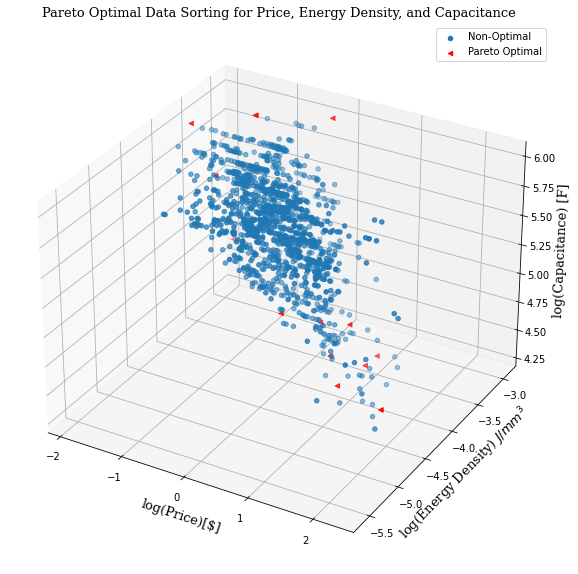

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13,
        }

fig = plt.figure()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
dp = np.array(list(dominatedPoints))
pp = np.array(list(paretoPoints))
print(pp.shape,dp.shape)
ax.scatter(np.log10(-dp[:,0]),np.log10(dp[:,1]),-np.log10(dp[:,2]))
ax.scatter(np.log10(-pp[:,0]),np.log10(pp[:,1]),-np.log10(pp[:,2]), color='red', marker = "<")
plt.legend(['Non-Optimal','Pareto Optimal'], loc = 'upper right')
plt.title('Pareto Optimal Data Sorting for Price, Energy Density, and Capacitance',  fontdict=font)
ax.set_xlabel('log(Price)[$]', rotation=150, fontdict=font)
ax.set_ylabel('log(Energy Density) $J/mm^3$', fontdict=font)
ax.set_zlabel('log(Capacitance) [F]',  rotation=60, fontdict=font)
plt.savefig("capacitors_3d.png",dpi=600)
plt.show()


We now find just the Pareto optimal points.

In [23]:
out = dfcap_ceram.loc[dfcap_ceram['Price'].isin(-pp[:,0])]
out =out.loc[out['energy_density'].isin(pp[:,1])]
out =out.loc[out['capacitance_absolute'].isin(pp[:,2])]
out


,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Package / Case,Size / Dimension,Height - Seated (Max),Thickness (Max),Lead Spacing,Lead Style,volume_mm,capacitance_absolute,energy,energy_density
13,http://www.samsungsem.com/kr/support/product-s...,//media.digikey.com/Renders/Samsung%20Electro-...,CL21B105KBFNNNF-ND,CL21B105KBFNNNF,Samsung Electro-Mechanics,Samsung Electro-Mechanics,CAP CER 1UF 50V X7R 0805,0,0.01273,0,...,0805 (2012 Metric),"0.079"" L x 0.049"" W (2.00mm x 1.25mm)",-,"0.053"" (1.35mm)",-,-,3.375,0.000001,0.000750,0.000222
15,https://www.samsungsem.com/kr/support/product-...,//media.digikey.com/Renders/Samsung%20Electro-...,CL31B225KBHNNNF-ND,CL31B225KBHNNNF,Samsung Electro-Mechanics,Samsung Electro-Mechanics,CAP CER 2.2UF 50V X7R 1206,0,0.03884,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.071"" (1.80mm)",-,-,9.216,0.000002,0.001651,0.000179
16,http://www.passivecomponent.com/wp-content/upl...,//media.digikey.com/Photos/Walsin%20Tech/1210-...,1292-1210B106K500CTTR-ND,1210B106K500CT,Walsin Technology Corporation,Walsin Technology Corporation,MLCC 10UF 50V X7R 1210,0,0.04055,0,...,1210 (3225 Metric),"0.126"" L x 0.098"" W (3.20mm x 2.50mm)",-,"0.110"" (2.80mm)",-,-,22.4,0.000010,0.007505,0.000335
32,https://www.murata.com/-/media/webrenewal/supp...,//media.digikey.com/Renders/Murata%20Renders/0...,GRM21BC81H475ME11K-ND,GRM21BC81H475ME11K,Murata Electronics,Murata Electronics,CAP CER 4.7UF 50V X6S 0805,0,0.06834,0,...,0805 (2012 Metric),"0.079"" L x 0.049"" W (2.00mm x 1.25mm)",-,"0.057"" (1.45mm)",-,-,3.625,0.000005,0.003527,0.000973
19,https://www.yuden.co.jp/productdata/catalog/ml...,//media.digikey.com/Renders/Taiyo%20Yuden%20Re...,"587-4949-2-ND,587-4949-1-ND,587-4949-6-ND",UMJ316AB7225MLHT,Taiyo Yuden,Taiyo Yuden,CAP CER 2.2UF 50V X7R 1206,6,0.56,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.071"" (1.80mm)",-,-,9.216,0.000002,0.001651,0.000179
59,https://product.tdk.com/system/files/dam/doc/p...,//media.digikey.com/Renders/TDK%20Renders/2220...,"445-C5750X7R1H226M250KBTR-ND,445-C5750X7R1H226...",C5750X7R1H226M250KB,TDK Corporation,TDK Corporation,COMMERCIAL GRADE GENERAL PURPOSE,0,5.1,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.110"" (2.80mm)",-,-,79.8,0.000022,0.016511,0.000207
10,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMCxx_s...,2571-GMC55X7R226M50NTTR-ND,GMC55X7R226M50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 22UF 50V X7R 2220,"50,500",2.1,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.138"" (3.50mm)",-,-,99.75,0.000022,0.016511,0.000166
45,https://datasheets.kyocera-avx.com/turbocap.pdf,//media.digikey.com/Photos/AVX%20Photos/ST121C...,478-6110-ND,ST125C506MAJ10,KYOCERA AVX,KYOCERA AVX,CAP CER 50UF 50V X7R SMD,38,46.29,0,...,"Stacked SMD, 20 J-Lead","1.050"" L x 0.250"" W (26.67mm x 6.35mm)",-,"0.140"" (3.56mm)",-,J-Lead,602.90202,0.000050,0.037525,0.000062
33,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C0603X7R...,2679-C0603X7R500-105KNPTR-ND,C0603X7R500-105KNP,Venkel,Venkel,CAP CER 1UF 50V X7R 0603,0,0.05833,0,...,0603 (1608 Metric),"0.063"" L x 0.031"" W (1.60mm x 0.80mm)",-,"0.039"" (0.99mm)",-,-,1.2672,0.000001,0.000750,0.000592
46,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C0603X7R...,2679-C1206X7R500-106KNETR-ND,C1206X7R500-106KNE,Venkel,Venkel,CAP CER 10UF 50V X7R 1206,0,0.15075,0,...,1206 (3216 Metric),"0.125"" L x 0.060"" W (3.18mm x 1.52mm)",-,"0.071"" (1.80mm)",-,-,8.70048,0.000010,0.007505,0.000863


<Figure size 432x288 with 0 Axes>

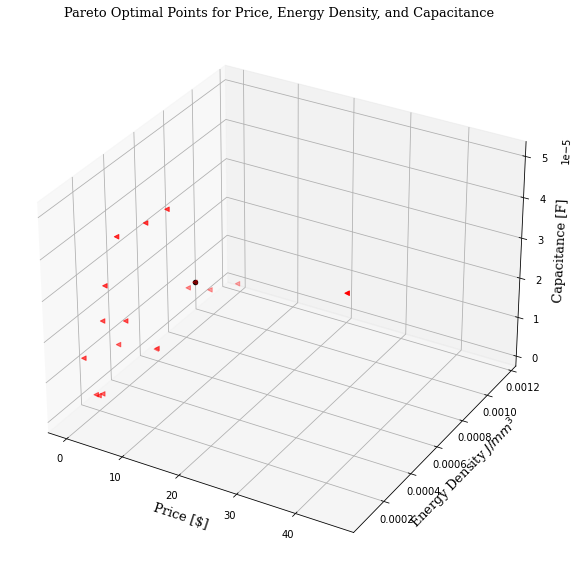

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13,
        }

fig = plt.figure()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(out['Price'],out['energy_density'],out['capacitance_absolute'], color='red', marker = "<")
ax.scatter(out['Price'].values[9],out['energy_density'].values[9],out['capacitance_absolute'].values[9], color='black')
plt.title('Pareto Optimal Points for Price, Energy Density, and Capacitance',  fontdict=font)
ax.set_xlabel('Price [$]', rotation=150, fontdict=font)
ax.set_ylabel('Energy Density $J/mm^3$', fontdict=font)
ax.set_zlabel('Capacitance [F]',  rotation=60, fontdict=font)
plt.savefig("capacitors_par2.png",dpi=600)
plt.show()


We now find a capacitor we like! https://www.digikey.com/en/products/detail/venkel/C1206X7R500-106KNE/12329161

## Finding C2
Now we can use the exact same methodology to find C2. We download new data that includes some switches rated for down to 25V.

In [25]:
path = "capc2/"

filenames = glob.glob(path + "/*.csv")
data_all2 = pd.DataFrame()

for file in filenames:
   # reading csv files
   data_all2 = pd.concat([data_all2, pd.read_csv(file)])

dfcap_ceram2 = data_all2

dfcap_ceram2

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Ratings,Applications,Failure Rate,Mounting Type,Package / Case,Size / Dimension,Height - Seated (Max),Thickness (Max),Lead Spacing,Lead Style
0,https://search.murata.co.jp/Ceramy/image/img/A...,//media.digikey.com/Renders/Murata%20Renders/0...,"490-7199-2-ND,490-7199-1-ND,490-7199-6-ND",GRM188C81E475KE11D,Murata Electronics,Murata Electronics,CAP CER 4.7UF 25V X6S 0603,0,0.26,0,...,-,General Purpose,-,"Surface Mount, MLCC",0603 (1608 Metric),"0.063"" L x 0.031"" W (1.60mm x 0.80mm)",-,"0.039"" (1.00mm)",-,-
1,https://search.murata.co.jp/Ceramy/image/img/A...,//media.digikey.com/Renders/Murata%20Renders/0...,"490-10023-2-ND,490-10023-1-ND,490-10023-6-ND",GRM188C81E475ME11D,Murata Electronics,Murata Electronics,CAP CER 4.7UF 25V X6S 0603,0,0.26,0,...,-,General Purpose,-,"Surface Mount, MLCC",0603 (1608 Metric),"0.063"" L x 0.031"" W (1.60mm x 0.80mm)",-,"0.039"" (1.00mm)",-,-
2,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C1206X7R...,2679-C1206X7R250-475MNETR-ND,C1206X7R250-475MNE,Venkel,Venkel,CAP CER 4.7UF 25V X7R 1206,0,0.05711,0,...,-,General Purpose,-,"Surface Mount, MLCC",1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.070"" (1.78mm)",-,-
3,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C1206X7R...,2679-C1206X7R250-475KNETR-ND,C1206X7R250-475KNE,Venkel,Venkel,CAP CER 4.7UF 25V X7R 1206,0,0.05711,0,...,-,General Purpose,-,"Surface Mount, MLCC",1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.070"" (1.78mm)",-,-
4,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C1206C0G...,2679-C1206X7R250-475KNUTR-ND,C1206X7R250-475KNU,Venkel,Venkel,CAP CER 4.7UF 25V X7R 1206,0,0.05711,0,...,-,General Purpose,-,"Surface Mount, MLCC",1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.070"" (1.78mm)",-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://content.kemet.com/datasheets/KEM_C1108...,//media.digikey.com/photos/Kemet%20Photos/MFG_...,"399-C1812C945K5RLCAUTOTR-ND,399-C1812C945K5RLC...",C1812C945K5RLCAUTO,KEMET,KEMET,CAP CER 9.4UF 50V X7R 1812,248,4.88,0,...,AEC-Q200,Automotive,-,"Surface Mount, MLCC",1812 (4532 Metric),"0.177"" L x 0.126"" W (4.50mm x 3.20mm)",-,"0.146"" (3.70mm)",-,-
96,https://connect.kemet.com:7667/gateway/Intelli...,//media.digikey.com/Renders/Kemet%20Renders/22...,"399-10019-2-ND,399-10019-1-ND,399-10019-6-ND",C2220C156K5RAC7800,KEMET,KEMET,CAP CER 15UF 50V X7R 2220,264,4.9,0,...,-,"Bypass, Decoupling",-,"Surface Mount, MLCC",2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.100"" (2.55mm)",-,-
97,https://datasheets.kyocera-avx.com/SR-Series.pdf,//media.digikey.com/Photos/AVX%20Photos/SR651E...,"478-7139-2-ND,478-7139-1-ND",SR655C106KARTR1,KYOCERA AVX,KYOCERA AVX,CAP CER 10UF 50V X7R RADIAL,164,4.9,0,...,-,General Purpose,-,Through Hole,Radial,"0.300"" L x 0.150"" W (7.62mm x 3.81mm)","0.400"" (10.16mm)",-,"0.200"" (5.08mm)",Formed Leads - Kinked
98,https://product.tdk.com/en/system/files?file=d...,//media.digikey.com/Photos/TDK%20Photos/CKG57K...,"445-10438-2-ND,445-10438-1-ND,445-10438-6-ND",CKG57KX7R1H475M335JJ,TDK Corporation,TDK Corporation,CAP CER 4.7UF 50V X7R SMD,764,4.95,0,...,AEC-Q200,"Automotive, SMPS Filtering, Bypass, Decoupling",-,"Surface Mount, MLCC","SMD, J-Lead","0.236"" L x 0.197"" W (6.00mm x 5.00mm)",-,"0.138"" (3.50mm)",-,J-Lead


In [26]:
volumecalc_ceram(dfcap_ceram2) # ['voltage_rated']
#filter out rows with invalid (non-numeric)
dfcap_ceram2 = dfcap_ceram2[~dfcap_ceram2.Price.str.contains('[\d\.]*', regex= True, na=False)]
#filter out rows with no volume
dfcap_ceram2 = dfcap_ceram2[dfcap_ceram2.volume_mm != "-"]
energydensity(dfcap_ceram2)

0.0006889301203162399
0.0006889301203162399
9.675984835902245e-05
9.675984835902245e-05
9.675984835902245e-05
9.568473893281107e-05
0.00011386806860223225
6.449558573173309e-05
0.00024326360110476887
9.568473893281107e-05
0.00024326360110476887
0.00022756917522704184
0.00020358455092087466
0.00024326360110476887
0.00024326360110476887
4.478860120259242e-05
0.00017690217800703941
0.0005175821300101466
2.8390734184776065e-05
0.00023515481440127657
0.00020358455092087466
0.0005019026899753178
4.2431306402455987e-05
0.00018129740008322102
3.6854620418133206e-05
0.0005175821300101466
0.00024326360110476887
8.376050095030275e-05
0.00010660427393674893
0.00024326360110476887
8.376050095030275e-05
0.00024326360110476887
0.0002612831271125295
9.568473893281107e-05
0.00018322609582878722
0.0001910980317977277
0.00018927156123184043
0.00018927156123184043
2.737677939246264e-05
0.00018427310209066604
2.346760752078526e-05
2.346760752078526e-05
0.0001810402406504789
0.00018427310209066604
2.7156036

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Package / Case,Size / Dimension,Height - Seated (Max),Thickness (Max),Lead Spacing,Lead Style,volume_mm,capacitance_absolute,energy,energy_density
0,https://search.murata.co.jp/Ceramy/image/img/A...,//media.digikey.com/Renders/Murata%20Renders/0...,"490-7199-2-ND,490-7199-1-ND,490-7199-6-ND",GRM188C81E475KE11D,Murata Electronics,Murata Electronics,CAP CER 4.7UF 25V X6S 0603,0,0.26,0,...,0603 (1608 Metric),"0.063"" L x 0.031"" W (1.60mm x 0.80mm)",-,"0.039"" (1.00mm)",-,-,1.28,0.000005,0.000882,0.000689
1,https://search.murata.co.jp/Ceramy/image/img/A...,//media.digikey.com/Renders/Murata%20Renders/0...,"490-10023-2-ND,490-10023-1-ND,490-10023-6-ND",GRM188C81E475ME11D,Murata Electronics,Murata Electronics,CAP CER 4.7UF 25V X6S 0603,0,0.26,0,...,0603 (1608 Metric),"0.063"" L x 0.031"" W (1.60mm x 0.80mm)",-,"0.039"" (1.00mm)",-,-,1.28,0.000005,0.000882,0.000689
2,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C1206X7R...,2679-C1206X7R250-475MNETR-ND,C1206X7R250-475MNE,Venkel,Venkel,CAP CER 4.7UF 25V X7R 1206,0,0.05711,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.070"" (1.78mm)",-,-,9.1136,0.000005,0.000882,0.000097
3,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C1206X7R...,2679-C1206X7R250-475KNETR-ND,C1206X7R250-475KNE,Venkel,Venkel,CAP CER 4.7UF 25V X7R 1206,0,0.05711,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.070"" (1.78mm)",-,-,9.1136,0.000005,0.000882,0.000097
4,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C1206C0G...,2679-C1206X7R250-475KNUTR-ND,C1206X7R250-475KNU,Venkel,Venkel,CAP CER 4.7UF 25V X7R 1206,0,0.05711,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.070"" (1.78mm)",-,-,9.1136,0.000005,0.000882,0.000097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,https://content.kemet.com/datasheets/KEM_C1108...,//media.digikey.com/photos/Kemet%20Photos/MFG_...,"399-C1812C945K5RLCAUTOTR-ND,399-C1812C945K5RLC...",C1812C945K5RLCAUTO,KEMET,KEMET,CAP CER 9.4UF 50V X7R 1812,248,4.88,0,...,1812 (4532 Metric),"0.177"" L x 0.126"" W (4.50mm x 3.20mm)",-,"0.146"" (3.70mm)",-,-,53.28,0.000009,0.007055,0.000132
96,https://connect.kemet.com:7667/gateway/Intelli...,//media.digikey.com/Renders/Kemet%20Renders/22...,"399-10019-2-ND,399-10019-1-ND,399-10019-6-ND",C2220C156K5RAC7800,KEMET,KEMET,CAP CER 15UF 50V X7R 2220,264,4.9,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.100"" (2.55mm)",-,-,72.675,0.000015,0.011257,0.000155
97,https://datasheets.kyocera-avx.com/SR-Series.pdf,//media.digikey.com/Photos/AVX%20Photos/SR651E...,"478-7139-2-ND,478-7139-1-ND",SR655C106KARTR1,KYOCERA AVX,KYOCERA AVX,CAP CER 10UF 50V X7R RADIAL,164,4.9,0,...,Radial,"0.300"" L x 0.150"" W (7.62mm x 3.81mm)","0.400"" (10.16mm)",-,"0.200"" (5.08mm)",Formed Leads - Kinked,115.83333,0.000010,0.007505,0.000065
98,https://product.tdk.com/en/system/files?file=d...,//media.digikey.com/Photos/TDK%20Photos/CKG57K...,"445-10438-2-ND,445-10438-1-ND,445-10438-6-ND",CKG57KX7R1H475M335JJ,TDK Corporation,TDK Corporation,CAP CER 4.7UF 50V X7R SMD,764,4.95,0,...,"SMD, J-Lead","0.236"" L x 0.197"" W (6.00mm x 5.00mm)",-,"0.138"" (3.50mm)",-,J-Lead,105.0,0.000005,0.003527,0.000034


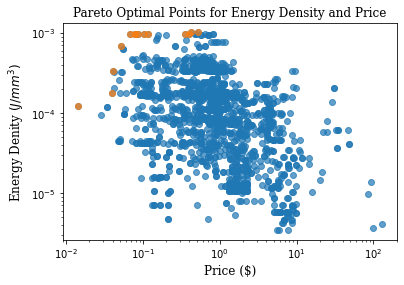

In [260]:
energy = np.asarray(dfcap_ceram2['energy_density'])
price = np.asarray(dfcap_ceram2['Price'])

#df = dfcap_ceram[Quantity(dfcap_ceram['voltage_rated']) >= 40]
#df =df[df['voltage_rated'] <= 400]

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

percentile_list = pd.DataFrame(
    {'energy': energy,
     'price': price,
    })

pare = percentile_list[percentile_list['energy'].notnull()]
pare = percentile_list[percentile_list['price'].notnull()]

#pareto_frontier(pare['price'].tolist(), pare['energy'].tolist(), maxX = True, maxY =True)

plt.title('Pareto Optimal Points for Energy Density and Price', fontdict=font)
plt.xlabel('Price ($)', fontdict=font)
plt.ylabel('Energy Denity $(J/mm^3)$ ', fontdict=font)
# Find minimizing pareto front for volume and the FOM
p_front = pareto_front.pareto_frontier(pare['price'].tolist(), pare['energy'].tolist(), maxX = False, maxY =True)
# Plot a scatter graph of all results
plt.scatter(price, energy, alpha=0.7)
# Then plot the Pareto frontier on top
plt.scatter(p_front[0], p_front[1],alpha=0.7)
plt.yscale('log',base=10) 
plt.xscale('log',base=10) 
plt.savefig("capacitorsc2_2d.png", format="png", dpi=600)

plt.show()

In [218]:
df3d2 = dfcap_ceram2.filter(['Price','energy_density', 'capacitance_absolute'], axis=1)
df3d2['Price'] = pd.to_numeric(df3d['Price'])
df3d2['Price'] = -1*df3d['Price']

#df3d['Voltage - Rated']= df3d['Voltage - Rated'].str.replace(r'\D', '').astype(float)
dataset2 = df3d2.values.tolist()

In [219]:
def simple_cull(inputPoints, dominates):
    paretoPoints = set()
    candidateRowNr = 0
    dominatedPoints = set()
    while True:
        candidateRow = inputPoints[candidateRowNr]
        inputPoints.remove(candidateRow)
        rowNr = 0
        nonDominated = True
        while len(inputPoints) != 0 and rowNr < len(inputPoints):
            row = inputPoints[rowNr]
            if dominates(candidateRow, row):
                # If it is worse on all features remove the row from the array
                inputPoints.remove(row)
                dominatedPoints.add(tuple(row))
            elif dominates(row, candidateRow):
                nonDominated = False
                dominatedPoints.add(tuple(candidateRow))
                rowNr += 1
            else:
                rowNr += 1

        if nonDominated:
            # add the non-dominated point to the Pareto frontier
            paretoPoints.add(tuple(candidateRow))

        if len(inputPoints) == 0:
            break
    return paretoPoints, dominatedPoints

def dominates(row, candidateRow):
    return sum([row[x] >= candidateRow[x] for x in range(len(row))]) == len(row)  

import random
#inputPoints = [[random.randint(70,100) for i in range(3)] for j in range(500)]
inputPoints = dataset2
paretoPoints, dominatedPoints = simple_cull(inputPoints, dominates)

In [222]:
dp

array([[5.00000000e-01, 2.35154814e-04, 4.70000000e-06],
       [4.50000000e+00, 4.71739141e-05, 3.30000000e-06],
       [4.34000000e+00, 4.71739141e-05, 3.30000000e-06],
       ...,
       [3.84000000e+00, 3.47450967e-05, 2.20000000e-06],
       [7.27700000e-02, 8.68627417e-05, 1.00000000e-05],
       [1.80000000e-01, 8.77856584e-05, 2.20000000e-06]])

(16, 3) (1240, 3)


<Figure size 432x288 with 0 Axes>

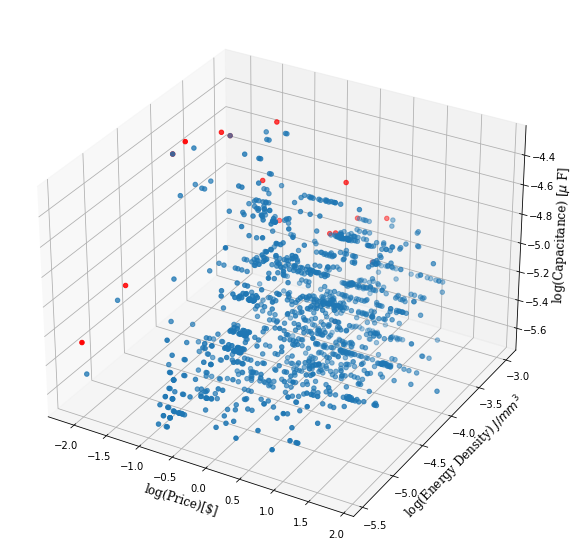

In [227]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

fig = plt.figure()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
dp = np.array(list(dominatedPoints))
pp = np.array(list(paretoPoints))
print(pp.shape,dp.shape)
ax.scatter(-np.log10(dp[:,0]),np.log10(dp[:,1]),np.log10(dp[:,2]))
ax.scatter(-np.log10(pp[:,0]),np.log10(pp[:,1]),np.log10(pp[:,2]), color='red')
ax.set_xlabel('log(Price)[$]', rotation=150, fontdict=font)
ax.set_ylabel('log(Energy Density) $J/mm^3$', fontdict=font)
ax.set_zlabel('log(Capacitance) [$\mu$ F]',  rotation=60, fontdict=font)
plt.savefig("capacitors_3dc2.png",dpi=600)
plt.show()


<Figure size 432x288 with 0 Axes>

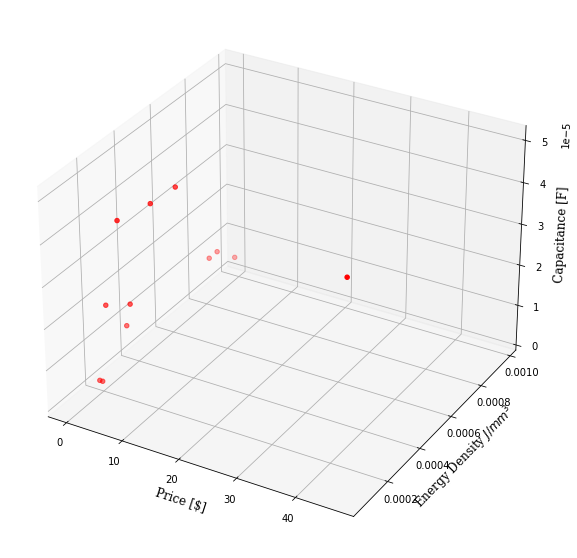

In [229]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
out2 = dfcap_ceram2.loc[dfcap_ceram2['Price'].isin(-pp[:,0])]
out2 =out.loc[out['energy_density'].isin(pp[:,1])]
out2 =out.loc[out['capacitance_absolute'].isin(pp[:,2])]
out2

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

fig = plt.figure()
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(out2['Price'],out2['energy_density'],out2['capacitance_absolute'], color='red')

#ax.scatter(out2['Price'].values[9],out2['energy_density'].values[9],out2['capacitance_absolute'].values[9], color='black')
ax.set_xlabel('Price [$]', rotation=150, fontdict=font)
ax.set_ylabel('Energy Density $J/mm^3$', fontdict=font)
ax.set_zlabel('Capacitance [F]',  rotation=60, fontdict=font)
plt.savefig("capacitors_par2c2.png",dpi=600)
plt.show()


In [230]:
out2

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Package / Case,Size / Dimension,Height - Seated (Max),Thickness (Max),Lead Spacing,Lead Style,volume_mm,capacitance_absolute,energy,energy_density
15,https://www.samsungsem.com/kr/support/product-...,//media.digikey.com/Renders/Samsung%20Electro-...,CL31B225KBHNNNF-ND,CL31B225KBHNNNF,Samsung Electro-Mechanics,Samsung Electro-Mechanics,CAP CER 2.2UF 50V X7R 1206,0,0.03884,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.071"" (1.80mm)",-,-,9.216,0.000002,0.001651,0.000179
16,http://www.passivecomponent.com/wp-content/upl...,//media.digikey.com/Photos/Walsin%20Tech/1210-...,1292-1210B106K500CTTR-ND,1210B106K500CT,Walsin Technology Corporation,Walsin Technology Corporation,MLCC 10UF 50V X7R 1210,0,0.04055,0,...,1210 (3225 Metric),"0.126"" L x 0.098"" W (3.20mm x 2.50mm)",-,"0.110"" (2.80mm)",-,-,22.4,0.000010,0.007505,0.000335
32,https://www.murata.com/-/media/webrenewal/supp...,//media.digikey.com/Renders/Murata%20Renders/0...,GRM21BC81H475ME11K-ND,GRM21BC81H475ME11K,Murata Electronics,Murata Electronics,CAP CER 4.7UF 50V X6S 0805,0,0.06834,0,...,0805 (2012 Metric),"0.079"" L x 0.049"" W (2.00mm x 1.25mm)",-,"0.057"" (1.45mm)",-,-,3.625,0.000005,0.003527,0.000973
19,https://www.yuden.co.jp/productdata/catalog/ml...,//media.digikey.com/Renders/Taiyo%20Yuden%20Re...,"587-4949-2-ND,587-4949-1-ND,587-4949-6-ND",UMJ316AB7225MLHT,Taiyo Yuden,Taiyo Yuden,CAP CER 2.2UF 50V X7R 1206,6,0.56,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.071"" (1.80mm)",-,-,9.216,0.000002,0.001651,0.000179
59,https://product.tdk.com/system/files/dam/doc/p...,//media.digikey.com/Renders/TDK%20Renders/2220...,"445-C5750X7R1H226M250KBTR-ND,445-C5750X7R1H226...",C5750X7R1H226M250KB,TDK Corporation,TDK Corporation,COMMERCIAL GRADE GENERAL PURPOSE,0,5.1,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.110"" (2.80mm)",-,-,79.8,0.000022,0.016511,0.000207
10,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GMCxx_s...,2571-GMC55X7R226M50NTTR-ND,GMC55X7R226M50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 22UF 50V X7R 2220,"50,500",2.1,0,...,2220 (5750 Metric),"0.224"" L x 0.197"" W (5.70mm x 5.00mm)",-,"0.138"" (3.50mm)",-,-,99.75,0.000022,0.016511,0.000166
45,https://datasheets.kyocera-avx.com/turbocap.pdf,//media.digikey.com/Photos/AVX%20Photos/ST121C...,478-6110-ND,ST125C506MAJ10,KYOCERA AVX,KYOCERA AVX,CAP CER 50UF 50V X7R SMD,38,46.29,0,...,"Stacked SMD, 20 J-Lead","1.050"" L x 0.250"" W (26.67mm x 6.35mm)",-,"0.140"" (3.56mm)",-,J-Lead,602.90202,0.000050,0.037525,0.000062
46,https://page.venkel.com/hubfs/Resources/Datash...,//media.digikey.com/Photos/Venkel/MFG_C0603X7R...,2679-C1206X7R500-106KNETR-ND,C1206X7R500-106KNE,Venkel,Venkel,CAP CER 10UF 50V X7R 1206,0,0.15075,0,...,1206 (3216 Metric),"0.125"" L x 0.060"" W (3.18mm x 1.52mm)",-,"0.071"" (1.80mm)",-,-,8.70048,0.000010,0.007505,0.000863
27,http://www.calchipelectronics.com/pdf/gmc_seri...,//media.digikey.com/Photos/CalChip/MFG_GCMXXXX...,2571-GMC31X7R106K50NTTR-ND,GMC31X7R106K50NT,"CAL-CHIP ELECTRONICS, INC.","CAL-CHIP ELECTRONICS, INC.",CAP CER 10UF 50V X7R 1206,"620,000",0.149,0,...,1206 (3216 Metric),"0.126"" L x 0.063"" W (3.20mm x 1.60mm)",-,"0.071"" (1.80mm)",-,-,9.216,0.000010,0.007505,0.000814
86,//media.digikey.com/pdf/Data%20Sheets/United%2...,//media.digikey.com/Photos/United%20Chemi-Con%...,"565-4687-2-ND,565-4687-1-ND,565-4687-6-ND",KTJ500B476M76BFT00,United Chemi-Con,United Chemi-Con,CAP CER 47UF 50V X7R SMD,"4,602",7.52,0,...,"Stacked SMD, 2 J-Lead","0.307"" L x 0.260"" W (7.80mm x 6.60mm)",-,"0.335"" (8.50mm)",-,J-Lead,437.58,0.000047,0.035273,0.000081


## Inductor Selection
We lastly do the same process for the inductor. However, we do not compute the energy density, as here we are interested in minimizing the DC winding resistance (DCR).

In [27]:
path = "ind/"

filenames = glob.glob(path + "/*.csv")
data_all3 = pd.DataFrame()

for file in filenames:
   # reading csv files
   data_all3 = pd.concat([data_all3, pd.read_csv(file)])

inductors = data_all3

inductors

#volumecalc_ceram(inductors)

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Frequency - Self Resonant,Ratings,Operating Temperature,Inductance Frequency - Test,Features,Mounting Type,Package / Case,Supplier Device Package,Size / Dimension,Height - Seated (Max)
0,https://www.vishay.com/docs/34022/ihv.pdf,-,IHV28BZ60-ND,IHV28BZ60,Vishay Dale,Vishay Dale,FIXED IND 60UH 28A 8.5 MOHM TH,12,16.38,0,...,1.9MHz,-,-55°C ~ 125°C,1 kHz,-,Through Hole,"Radial, Horizontal Cylinder",-,"1.020"" Dia x 2.450"" L (25.91mm x 62.23mm)",-
1,https://www.vishay.com/docs/34353/ihlp8787mz51...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER750M51TR-ND,541-IHLP8787MZER75...",IHLP8787MZER750M51,Vishay Dale,Vishay Dale,FIXED IND 75UH 12A 32.35 MOHM SM,209,10.02,0,...,2.01MHz,-,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)"
2,https://www.vishay.com/docs/34353/ihlp8787mz51...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER820M51TR-ND,541-IHLP8787MZER82...",IHLP8787MZER820M51,Vishay Dale,Vishay Dale,FIXED IND 82UH 10.2A 34.2MOHM SM,200,12.21,0,...,2.07MHz,-,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)"
3,https://www.vishay.com/docs/34350/ihlp8787mz5a...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER470M5ATR-ND,541-IHLP8787MZER47...",IHLP8787MZER470M5A,Vishay Dale,Vishay Dale,IHLP-8787MZ-5A 47 20% ER E3,9,10.27,0,...,2.99MHz,AEC-Q200,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)"
4,https://www.vishay.com/docs/34350/ihlp8787mz5a...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER820M5ATR-ND,541-IHLP8787MZER82...",IHLP8787MZER820M5A,Vishay Dale,Vishay Dale,FIXED IND 82UH 10.2A 34.2MOHM SM,200,10.27,0,...,2.07MHz,AEC-Q200,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,-,-,SDO-48-0006-ND,SDO-48-0006,Schurter Inc.,Schurter Inc.,FIXED IND 160UH 16A SMD,0,Obsolete,0,...,-,-,-,-,-,Surface Mount,Nonstandard,-,-,-
245,https://www.itg-electronics.com/files/b1b65e2b...,//media.digikey.com/Photos/ITG-Electronics/MFG...,3013-SLQ40407A-1R5MHFTR-ND,SLQ40407A-1R5MHF,"ITG Electronics, Inc.","ITG Electronics, Inc.","1.5UH, 20%, 0.73MOHM, 10.0A MAX.",0,Active,0,...,-,-,-55°C ~ 130°C,500 kHz,-,Surface Mount,2-SMD,-,"0.394"" L x 0.275"" W (10.00mm x 7.00mm)","0.394"" (10.00mm)"
246,https://www.itg-electronics.com/files/eedcc39a...,//media.digikey.com/Photos/ITG-Electronics/MFG...,3013-L201316Q-101MHFTR-ND,L201316Q-101MHF,"ITG Electronics, Inc.","ITG Electronics, Inc.","105.0UH, 20%, 7.10MOHM, 25.0A MA",0,Active,0,...,-,AEC-Q200,-55°C ~ 150°C,10 kHz,-,Through Hole,2-DIP,2-DIP,"1.299"" L x 1.259"" W (33.00mm x 32.00mm)","1.244"" (31.60mm)"
247,https://www.itg-electronics.com/files/ce92aa60...,//media.digikey.com/Photos/ITG-Electronics/MFG...,3013-PQ108081H-101MHFTR-ND,PQ108081H-101MHF,"ITG Electronics, Inc.","ITG Electronics, Inc.","100.00UH, 20%, 28.50MOHM, 10.30A",0,Active,0,...,-,-,-55°C ~ 130°C,300 kHz,-,Surface Mount,3-SMD,3-SMD,"1.100"" L x 1.100"" W (27.94mm x 27.94mm)","0.787"" (20.00mm)"


In [28]:
inductors['DC Resistance (DCR)'] = inductors['DC Resistance (DCR)'].map(lambda x: x.rstrip(' Max'))

In [29]:
def volumecalc_ind(df):

    volumes_mm = []
    for i in range(0,df.shape[0]):
        
        if df['Size / Dimension'].values[i] == '-':
            volume = "-"
        
        #prism volume calculation
        elif re.findall("Dia", df['Size / Dimension'].values[i]) == []:
            if df['Height - Seated (Max)'].values[i] == '-':
                volume = "-"
            else:
                length = pd.to_numeric(re.findall(r'((?<=\()[\d\.]*)', df['Size / Dimension'].values[i])[0])
                width = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Size / Dimension'].values[i])[0])
                height = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Height - Seated (Max)'].values[i])[0])

                volume = length * width * height
        
        #cylinder volume calculation
        else:
            diameter = pd.to_numeric(re.findall(r'((?<=\()[\d\.]*)', df['Size / Dimension'].values[i])[0])
            
            if df['Height - Seated (Max)'].values[i] == '-':
                height = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Size / Dimension'].values[i])[0])
            else:
                height = pd.to_numeric(re.findall(r'([\d\.]*(?=mm\)))', df['Height - Seated (Max)'].values[i])[0])
            
            volume = np.pi * ((diameter/2)**2) * height
            
        volumes_mm.append(volume)
        
        
    df['volume_mm'] = volumes_mm

    return df

In [30]:
volumecalc_ind(inductors)

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Ratings,Operating Temperature,Inductance Frequency - Test,Features,Mounting Type,Package / Case,Supplier Device Package,Size / Dimension,Height - Seated (Max),volume_mm
0,https://www.vishay.com/docs/34022/ihv.pdf,-,IHV28BZ60-ND,IHV28BZ60,Vishay Dale,Vishay Dale,FIXED IND 60UH 28A 8.5 MOHM TH,12,16.38,0,...,-,-55°C ~ 125°C,1 kHz,-,Through Hole,"Radial, Horizontal Cylinder",-,"1.020"" Dia x 2.450"" L (25.91mm x 62.23mm)",-,32811.380887
1,https://www.vishay.com/docs/34353/ihlp8787mz51...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER750M51TR-ND,541-IHLP8787MZER75...",IHLP8787MZER750M51,Vishay Dale,Vishay Dale,FIXED IND 75UH 12A 32.35 MOHM SM,209,10.02,0,...,-,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)",6429.28
2,https://www.vishay.com/docs/34353/ihlp8787mz51...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER820M51TR-ND,541-IHLP8787MZER82...",IHLP8787MZER820M51,Vishay Dale,Vishay Dale,FIXED IND 82UH 10.2A 34.2MOHM SM,200,12.21,0,...,-,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)",6429.28
3,https://www.vishay.com/docs/34350/ihlp8787mz5a...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER470M5ATR-ND,541-IHLP8787MZER47...",IHLP8787MZER470M5A,Vishay Dale,Vishay Dale,IHLP-8787MZ-5A 47 20% ER E3,9,10.27,0,...,AEC-Q200,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)",6429.28
4,https://www.vishay.com/docs/34350/ihlp8787mz5a...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,"541-IHLP8787MZER820M5ATR-ND,541-IHLP8787MZER82...",IHLP8787MZER820M5A,Vishay Dale,Vishay Dale,FIXED IND 82UH 10.2A 34.2MOHM SM,200,10.27,0,...,AEC-Q200,-55°C ~ 155°C,100 kHz,-,Surface Mount,Nonstandard,-,"0.885"" L x 0.866"" W (22.48mm x 22.00mm)","0.512"" (13.00mm)",6429.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,-,-,SDO-48-0006-ND,SDO-48-0006,Schurter Inc.,Schurter Inc.,FIXED IND 160UH 16A SMD,0,Obsolete,0,...,-,-,-,-,Surface Mount,Nonstandard,-,-,-,-
245,https://www.itg-electronics.com/files/b1b65e2b...,//media.digikey.com/Photos/ITG-Electronics/MFG...,3013-SLQ40407A-1R5MHFTR-ND,SLQ40407A-1R5MHF,"ITG Electronics, Inc.","ITG Electronics, Inc.","1.5UH, 20%, 0.73MOHM, 10.0A MAX.",0,Active,0,...,-,-55°C ~ 130°C,500 kHz,-,Surface Mount,2-SMD,-,"0.394"" L x 0.275"" W (10.00mm x 7.00mm)","0.394"" (10.00mm)",700.0
246,https://www.itg-electronics.com/files/eedcc39a...,//media.digikey.com/Photos/ITG-Electronics/MFG...,3013-L201316Q-101MHFTR-ND,L201316Q-101MHF,"ITG Electronics, Inc.","ITG Electronics, Inc.","105.0UH, 20%, 7.10MOHM, 25.0A MA",0,Active,0,...,AEC-Q200,-55°C ~ 150°C,10 kHz,-,Through Hole,2-DIP,2-DIP,"1.299"" L x 1.259"" W (33.00mm x 32.00mm)","1.244"" (31.60mm)",33369.6
247,https://www.itg-electronics.com/files/ce92aa60...,//media.digikey.com/Photos/ITG-Electronics/MFG...,3013-PQ108081H-101MHFTR-ND,PQ108081H-101MHF,"ITG Electronics, Inc.","ITG Electronics, Inc.","100.00UH, 20%, 28.50MOHM, 10.30A",0,Active,0,...,-,-55°C ~ 130°C,300 kHz,-,Surface Mount,3-SMD,3-SMD,"1.100"" L x 1.100"" W (27.94mm x 27.94mm)","0.787"" (20.00mm)",15612.872


We next filter for just Vishay Dale inductors that are still sold, and are not obsolete. These allow us to use our loss function.

In [31]:

inductors = inductors[inductors['DC Resistance (DCR)'] != "-"]
inductors = inductors[inductors['volume_mm'] != "-"]
inductors = inductors[inductors['Price'] != "Obsolete"]
inductors = inductors[inductors['Mfr'] == "Vishay Dale"]
X = []
Y=[]
for i in range(0,len(inductors['DC Resistance (DCR)'])):
    x = inductors['DC Resistance (DCR)'].values[i]
    X.append(Quantity(x))
    y = inductors['Current Rating (Amps)'].values[i]
    Y.append(Quantity(y))
    
inductors['DC Resistance (DCR)'] = X
inductors['DC Resistance (DCR)'] = pd.to_numeric(inductors['DC Resistance (DCR)'])
inductors['volume_mm'] = pd.to_numeric(inductors['volume_mm'])
inductors['Current Rating (Amps)'] = pd.to_numeric(Y)


Next, for inductors under 100uH (I downloaded data for as low as 47uH), we do some math to double them, so that they are large enough. We must double inductance, volume, and resistance for our purposes.

In [32]:
X = []
Y = []
Z =[]
for i in range(0,len(inductors['DC Resistance (DCR)'])):
    if Quantity(inductors['Inductance'].values[i]) < 100e-6:        
        x = 2*Quantity(inductors['Inductance'].values[i])
        y = 2*Quantity(inductors['volume_mm'].values[i])
        z = 2*Quantity(inductors['DC Resistance (DCR)'].values[i])
    else:
        x  = Quantity(inductors['Inductance'].values[i])
        y = Quantity(inductors['volume_mm'].values[i])
        z = Quantity(inductors['DC Resistance (DCR)'].values[i])
    X.append(Quantity(x))
    Y.append(Quantity(y))
    Z.append(Quantity(z))
inductors['dcreq'] = Z
inductors['indeq'] = X
inductors['voleq'] = Y
inductors = inductors[(inductors['indeq'] < 1)&(inductors['voleq'] > 7000)&(inductors['Current Rating (Amps)'] < 100)]


Pareto time!

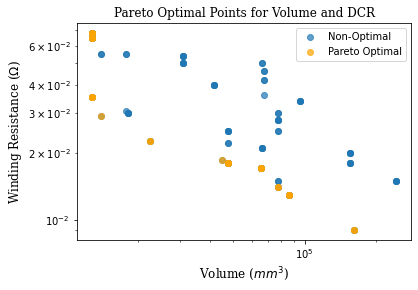

In [33]:
vol = np.asarray(inductors['voleq'])
res = np.asarray(inductors['dcreq'])

#df = dfcap_ceram[Quantity(dfcap_ceram['voltage_rated']) >= 40]
#df =df[df['voltage_rated'] <= 400]

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

percentile_list = pd.DataFrame(
    {'vol': vol,
     'res': res,
    })

pare = percentile_list[percentile_list['vol'].notnull()]
pare = percentile_list[percentile_list['res'].notnull()]

#pareto_frontier(pare['price'].tolist(), pare['energy'].tolist(), maxX = True, maxY =True)

plt.title('Pareto Optimal Points for Volume and DCR', fontdict=font)
plt.xlabel('Volume ($mm^3$)', fontdict=font)
plt.ylabel('Winding Resistance ($\Omega$) ', fontdict=font)
# Find minimizing pareto front for volume and the FOM
p_front = pareto_front.pareto_frontier(pare['vol'].tolist(), pare['res'].tolist(), maxX = False, maxY =False)


y = inductors[inductors['Mfr Part #'].str.contains("IHLP")]

# Plot a scatter graph of all results
plt.scatter(vol, res, alpha=0.7)
plt.scatter(y['voleq'], y['dcreq'], alpha=0.7, color = 'orange')
# Then plot the Pareto frontier on top
plt.scatter(p_front[0], p_front[1],alpha=0.7, color = 'orange')
plt.yscale('log',base=10) 
plt.xscale('log',base=10) 
plt.legend(['Non-Optimal','Pareto Optimal'], loc = 'upper right')
plt.savefig("inductoroni.png", format="png", dpi=600)

plt.show()

In [34]:
out = inductors.loc[inductors['voleq'].isin(p_front[0])]
out =out.loc[out['DC Resistance (DCR)'].isin(p_front[1])]
out

,Datasheet,Image,DK Part #,Mfr Part #,Mfr,Supplier,Description,Stock,Price,@ qty,...,Features,Mounting Type,Package / Case,Supplier Device Package,Size / Dimension,Height - Seated (Max),volume_mm,dcreq,indeq,voleq
17,https://www.vishay.com/docs/34022/ihv.pdf,-,IHV30BZ150-ND,IHV30BZ150,Vishay Dale,Vishay Dale,FIXED IND 150UH 30A 13 MOHM TH,0,33.266,0,...,-,Through Hole,"Radial, Horizontal Cylinder",-,"1.650"" Dia x 2.450"" L (41.91mm x 62.23mm)",-,85846.976490,0.0130,0.00015,85846.976490
23,https://www.vishay.com/docs/34015/ihb.pdf,-,IHB6BV101K-ND,IHB6BV101K,Vishay Dale,Vishay Dale,FIXED IND 100UH 16.4A 14 MOHM TH,0,32.66313,0,...,-,Through Hole,"Radial, Vertical Cylinder",-,"2.000"" Dia (50.80mm)","1.500"" (38.10mm)",77222.219814,0.0140,0.00010,77222.219814
25,https://www.vishay.com/docs/34022/ihv.pdf,-,IHV30EB150-ND,IHV30EB150,Vishay Dale,Vishay Dale,FIXED IND 150UH 30A 13 MOHM TH,0,32.296,0,...,-,Through Hole,"Radial, Horizontal Cylinder",-,"1.650"" Dia x 2.450"" L (41.91mm x 62.23mm)",-,85846.976490,0.0130,0.00015,85846.976490
30,https://www.vishay.com/docs/34015/ihb.pdf,-,IHB5EB101K-ND,IHB5EB101K,Vishay Dale,Vishay Dale,FIXED IND 100UH 12.1A 18 MOHM TH,0,17.84563,0,...,-,Through Hole,"Radial, Vertical Cylinder",-,"1.600"" Dia (40.64mm)","1.450"" (36.83mm)",47774.813325,0.0180,0.00010,47774.813325
34,https://www.vishay.com/docs/34015/ihb.pdf,-,IHB5BV101K-ND,IHB5BV101K,Vishay Dale,Vishay Dale,FIXED IND 100UH 12.1A 18 MOHM TH,0,18.375,0,...,-,Through Hole,"Radial, Vertical Cylinder",-,"1.600"" Dia (40.64mm)","1.450"" (36.83mm)",47774.813325,0.0180,0.00010,47774.813325
47,https://www.vishay.com/docs/34559/ihth-1500tz-...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,541-IHTH1500TZEB101M5A-ND,IHTH1500TZEB101M5A,Vishay Dale,Vishay Dale,IHTH-1500TZ-5A 100 20% EB E2,0,12.012,0,...,-,Through Hole,"Radial, Vertical Cylinder, 4 Leads",Radial,"1.500"" Dia (38.10mm)","0.780"" (19.81mm)",22585.219112,0.0226,0.00010,22585.219112
152,https://www.vishay.com/docs/34559/ihth-1500tz-...,//media.digikey.com/Photos/Vishay%20Dale%20Pho...,541-IHTH1500TZEB101M5A-ND,IHTH1500TZEB101M5A,Vishay Dale,Vishay Dale,IHTH-1500TZ-5A 100 20% EB E2,0,12.012,0,...,-,Through Hole,"Radial, Vertical Cylinder, 4 Leads",Radial,"1.500"" Dia (38.10mm)","0.780"" (19.81mm)",22585.219112,0.0226,0.00010,22585.219112
162,https://www.vishay.com/docs/34015/ihb.pdf,-,IHB5EB101K-ND,IHB5EB101K,Vishay Dale,Vishay Dale,FIXED IND 100UH 12.1A 18 MOHM TH,0,17.84563,0,...,-,Through Hole,"Radial, Vertical Cylinder",-,"1.600"" Dia (40.64mm)","1.450"" (36.83mm)",47774.813325,0.0180,0.00010,47774.813325
166,https://www.vishay.com/docs/34015/ihb.pdf,-,IHB5BV101K-ND,IHB5BV101K,Vishay Dale,Vishay Dale,FIXED IND 100UH 12.1A 18 MOHM TH,0,18.375,0,...,-,Through Hole,"Radial, Vertical Cylinder",-,"1.600"" Dia (40.64mm)","1.450"" (36.83mm)",47774.813325,0.0180,0.00010,47774.813325
185,https://www.vishay.com/docs/34022/ihv.pdf,-,IHV30EB150-ND,IHV30EB150,Vishay Dale,Vishay Dale,FIXED IND 150UH 30A 13 MOHM TH,0,32.296,0,...,-,Through Hole,"Radial, Horizontal Cylinder",-,"1.650"" Dia x 2.450"" L (41.91mm x 62.23mm)",-,85846.976490,0.0130,0.00015,85846.976490
